<a href="https://colab.research.google.com/github/frh02/CAN_Research/blob/main/LSTM_CAN_Binary_Classifier_Conf_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model for Binary Classification

## import libraries 

In [19]:
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import keras.utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
from keras import utils as np_utils
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
import pandas as pd
import csv
%matplotlib inline  
from ast import literal_eval 
import array as array

## load the data

In [21]:
df1 = pd.read_csv('/content/Train.csv')
df2= pd.read_csv('/content/Test.csv')
frames= [df1,df2]
df = pd.concat(frames)
df = df.fillna(-1)
df.to_csv('input_train.csv')
print(df)

       Unnamed: 0        Time   seconds   ID  Value  ...  D5  D6  D7  D8 Target
0               0  Timestamp:  0.000000  ID:    790  ...  20  1a  00  7f      0
1               1  Timestamp:  0.000224  ID:    809  ...  11  2f  00  10      0
2               2  Timestamp:  0.000462  ID:    128  ...  20  1a  20  43      0
3               3  Timestamp:  0.000704  ID:    129  ...  00  00  00  53      0
4               4  Timestamp:  0.000878  ID:    288  ...  -1  -1  -1  -1      0
...           ...         ...       ...  ...    ...  ...  ..  ..  ..  ..    ...
19995       19995  Timestamp:  7.114431  ID:    848  ...  86   0   0  c8      1
19996       19996  Timestamp:  7.114927  ID:    880  ...  ff   0   0  ec      1
19997       19997  Timestamp:  7.115429  ID:    898  ...   0   0   0   4      1
19998       19998  Timestamp:  7.116169  ID:      0  ...   0   0   0   0      1
19999       19999  Timestamp:  7.116921  ID:   1201  ...   0   0   0   1      1

[90000 rows x 17 columns]


## cleaning the data 

In [22]:
properties = list(df.columns.values)
properties.remove('Time')
properties.remove('seconds')
properties.remove('ID')
properties.remove('DLC')
properties.remove('App')
properties.remove('Unnamed: 0')
properties.remove('Target')
df['D1']=df['D1'].apply(lambda x: int(str(x),16))
df['D2']=df['D2'].apply(lambda x: int(str(x),16))
df['D3']=df['D3'].apply(lambda x: int(str(x),16))
df['D4']=df['D4'].apply(lambda x: int(str(x),16))
df['D5']=df['D5'].apply(lambda x: int(str(x),16))
df['D6']=df['D6'].apply(lambda x: int(str(x),16))
df['D7']=df['D7'].apply(lambda x: int(str(x),16))
df['D8']=df['D8'].apply(lambda x: int(str(x),16))
X = df[properties]
y = df['Target']
print(y.shape)
X = np.expand_dims(X, axis=2)
y = np.expand_dims(y, axis=1)
print(X.shape)
print(y.shape)


(90000,)
(90000, 10, 1)
(90000, 1)


## 2D To 3D array conversion

In [23]:
TIME_STEPS = 288
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)

training_value = df 
x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Training input shape:  (89712, 288, 1, 17)


## creating the LSTM model 

In [24]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

keras.backend.clear_session()
model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        layers.LSTM(
            units=256, activation="tanh", name="lstm_1", return_sequences=False
        ),
        layers.RepeatVector(n_steps),
        layers.LSTM(
            units=128, activation="tanh", name="lstm_2", return_sequences=True
        ),
        layers.LSTM(
            units=128, activation="tanh", name="lstm_3", return_sequences=True
        ),
        layers.LSTM(
            units=64, activation="tanh", name="lstm_4", return_sequences=True
        ),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),

        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 32)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 32)            3

In [25]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)
    ],
)

Epoch 1/100
443/443 [==============================] - 42s 13ms/step - loss: 0.3178 - accuracy: 0.8848 - val_loss: 0.2128 - val_accuracy: 0.9283
Epoch 2/100
443/443 [==============================] - 5s 10ms/step - loss: 0.2247 - accuracy: 0.9351 - val_loss: 0.3048 - val_accuracy: 0.9305
Epoch 3/100
443/443 [==============================] - 5s 11ms/step - loss: 0.2447 - accuracy: 0.9331 - val_loss: 0.5297 - val_accuracy: 0.9187
Epoch 4/100
443/443 [==============================] - 5s 10ms/step - loss: 0.2707 - accuracy: 0.9277 - val_loss: 0.2358 - val_accuracy: 0.9206
Epoch 5/100
443/443 [==============================] - 5s 10ms/step - loss: 0.2452 - accuracy: 0.9316 - val_loss: 0.3237 - val_accuracy: 0.9077
Epoch 6/100
443/443 [==============================] - 5s 10ms/step - loss: 0.2284 - accuracy: 0.9257 - val_loss: 0.1975 - val_accuracy: 0.9345
Epoch 7/100
443/443 [==============================] - 5s 10ms/step - loss: 0.2527 - accuracy: 0.9196 - val_loss: 0.1904 - val_accuracy

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

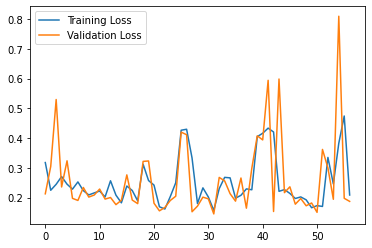

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

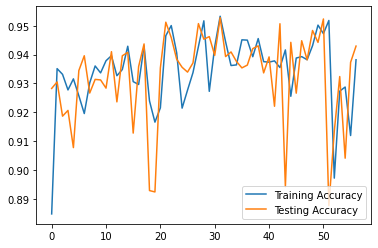

In [28]:
plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Testing Accuracy")
plt.legend()
plt.show()

## Using DNN model for same data 

In [29]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(10,)),
    keras.layers.Dense(256, activation=tf.nn.relu),
	  keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/100
394/394 [==============================] - 2s 3ms/step - loss: 0.4347 - accuracy: 0.8946 - val_loss: 0.2909 - val_accuracy: 0.9041
Epoch 2/100
394/394 [==============================] - 1s 3ms/step - loss: 0.2370 - accuracy: 0.9258 - val_loss: 0.3037 - val_accuracy: 0.8704
Epoch 3/100
394/394 [==============================] - 1s 3ms/step - loss: 0.2127 - accuracy: 0.9354 - val_loss: 0.2010 - val_accuracy: 0.9399
Epoch 4/100
394/394 [==============================] - 1s 3ms/step - loss: 0.1904 - accuracy: 0.9427 - val_loss: 0.1802 - val_accuracy: 0.9374
Epoch 5/100
394/394 [==============================] - 1s 3ms/step - loss: 0.1774 - accuracy: 0.9459 - val_loss: 0.1710 - val_accuracy: 0.9451
Epoch 6/100
394/394 [==============================] - 1s 3ms/step - loss: 0.1673 - accuracy: 0.9485 - val_loss: 0.2103 - val_accuracy: 0.9102
Epoch 7/100
394/394 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.9497 - val_loss: 0.1712 - val_accuracy: 0.9452

In [31]:
history.history['accuracy']


[0.8945833444595337,
 0.9258134961128235,
 0.9353770017623901,
 0.9426785707473755,
 0.945892870426178,
 0.948452353477478,
 0.9496825337409973,
 0.9517063498497009,
 0.9490873217582703,
 0.9501388669013977,
 0.9491269588470459,
 0.9509127140045166,
 0.9493253827095032,
 0.9503968358039856,
 0.9519047737121582,
 0.9505555629730225,
 0.9524206519126892,
 0.951884925365448,
 0.9530357122421265,
 0.9507539868354797,
 0.9512698650360107,
 0.9511706233024597,
 0.9535317420959473,
 0.9500396847724915,
 0.9506944417953491,
 0.9538690447807312,
 0.9536706209182739,
 0.9501984119415283,
 0.9541468024253845,
 0.9543452262878418,
 0.9543253779411316,
 0.9448412656784058,
 0.9529365301132202,
 0.953769862651825,
 0.9543055295944214,
 0.9539880752563477,
 0.9543849229812622,
 0.9524206519126892,
 0.9539087414741516,
 0.954285740852356,
 0.9540476202964783,
 0.9543849229812622,
 0.9504761695861816,
 0.9542460441589355,
 0.9544642567634583,
 0.9545634984970093,
 0.9543452262878418,
 0.953015863895416

In [32]:
history.history['val_accuracy']

[0.9041270017623901,
 0.8703968524932861,
 0.9399206638336182,
 0.9373809695243835,
 0.9450793862342834,
 0.9102380871772766,
 0.9452381134033203,
 0.9456349015235901,
 0.9470635056495667,
 0.9411110877990723,
 0.940079391002655,
 0.942380964756012,
 0.9477777481079102,
 0.9417460560798645,
 0.9480952620506287,
 0.9471428394317627,
 0.9479365348815918,
 0.9476190209388733,
 0.946587324142456,
 0.9487301707267761,
 0.9374603033065796,
 0.9491269588470459,
 0.9474602937698364,
 0.9439682364463806,
 0.9459523558616638,
 0.9494444727897644,
 0.9495238065719604,
 0.9485714435577393,
 0.9492856860160828,
 0.9493650794029236,
 0.9492063522338867,
 0.9442856907844543,
 0.9492856860160828,
 0.948968231678009,
 0.9492856860160828,
 0.9494444727897644,
 0.9493650794029236,
 0.9453968405723572,
 0.9495238065719604,
 0.9485714435577393,
 0.9486507773399353,
 0.9495238065719604,
 0.9491269588470459,
 0.9495238065719604,
 0.9496031999588013,
 0.9496031999588013,
 0.9469841122627258,
 0.94833332300186

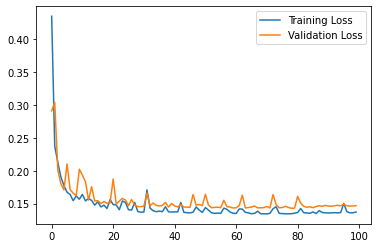

In [33]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

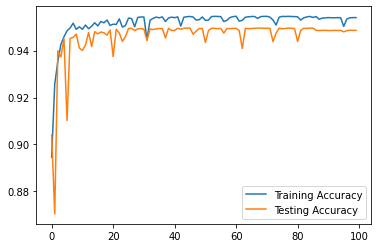

In [34]:
plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Testing Accuracy")
plt.legend()
plt.show()

## Consfusion Matrix 

In [ ]:
import pandas as pd
y_actu = pd.Series([3, 3, 0, 3, 1, 2, 0, 3, 2, 1, 3, 0, 0, 3, 1, 2, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 2, 1, 3, 1, 2, 3, 0, 3, 2, 0, 2, 0, 3, 1, 1, 0, 3, 2, 0, 2, 0, 3, 1, 0, 2, 3, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0], name='Actual')
y_pred_new = pd.Series([0, 3, 0, 3, 1, 0, 3, 3, 0, 0, 3, 0, 0, 3, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 3, 1, 2, 2, 1, 3, 1, 2, 3, 0, 3, 2, 0, 2, 0, 3, 1, 1, 0, 3, 2, 0, 2, 0, 3, 1, 0, 2, 3, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0, 0], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred_new)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_conf_norm)

In [ ]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


In [39]:
y_pred = model.predict(X_test) #prediction
y_pred = (y_pred > 0.5)


Normalized confusion matrix
[[1.00e+00 1.43e-04]
 [2.16e-01 7.84e-01]]


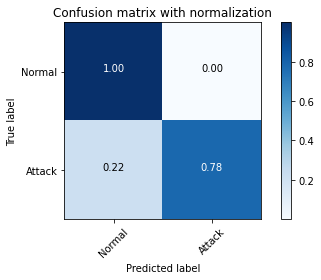

In [44]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','Attack'],
                      title='Confusion matrix with normalization')

In [ ]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_actu, y_pred_new)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','DoS', 'Fuzzing','Impersonation'],
                      title='Confusion matrix with normalization')